# Quantify **Organelle Morphology** - part 2.1
--------------------
Now that all organelles and masks are segmented, we can begin to quantify features of organelle **composition**, **morphology**, **interactions**, and **distribution**. 


## **OBJECTIVE**
### <input type="checkbox"/> Quantify ***organelle composition and morphology***
In this notebook, the logic for quantifying **organelle composition** (how much of each organelle is present) and **morphology** (individual size and shape) is outlined.


--------
## **Organelle Morphology**

### summary of steps

🛠️ **BUILD FUNCTION PROTOTYPE**

- **`0`** - Apply Cell Mask *(preliminary step)*

- **`1`** - Build the list of measurements we want to include from regionprops 

- **`2`** - Add additional measurements as *"extra_properties"* with custom functions.

- **`3`** - Run regionprops and export values as a pandas dataframe

- **`4`** - Add additional measurements
    - surface area
    - surface area to volume ratio

⚙️ **EXECUTE FUNCTION PROTOTYPE**

- Define `_get_org_morphology_3D` function
- Run `_get_org_morphology_3D` function
    - scaled and unscaled
- Compare to finalized `get_org_morphology_3D` function

## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [ ]:
from pathlib import Path
import os

import napari
from napari.utils.notebook_display import nbscreenshot

from skimage.measure import (regionprops, regionprops_table)

from infer_subc.core.file_io import (read_czi_image,
                                     import_inferred_organelle,
                                     list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_assert_uint16_labels)
from infer_subc.utils.stats_helpers import *
from infer_subc.organelles import * 

%load_ext autoreload
%autoreload 2

## **LOAD AND READ IN IMAGE FOR PROCESSING**
> ###### 📝 **Specifically, this will include the raw image and the outputs from segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
## Define the path to the directory that contains the input image folder.
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

## Specify which subfolder that contains the input data and what the file type is. Ex) ".czi" or ".tiff"
in_data_path = data_root_path / "raw_single"
raw_img_type = ".czi"

## Specify which subfolder contains the segmentation outputs and their file type
seg_data_path = data_root_path / "out_single"
seg_img_type = ".tiff"

## Specify the name of the output folder where quantification results will be saved
out_data_path = data_root_path / "quant_single"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0


#### &#x1F3C3; **Run code; no user input required**

In [ ]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

raw_file_list = list_image_files(in_data_path, raw_img_type)
seg_file_list = list_image_files(seg_data_path, seg_img_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [ ]:
raw_img_name = raw_file_list[test_img_n]

raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [ ]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("nuc", raw_meta_dict, seg_data_path, seg_img_type)
cell_seg = import_inferred_organelle("cell", raw_meta_dict, seg_data_path, seg_img_type)
cyto_seg = import_inferred_organelle("cyto", raw_meta_dict, seg_data_path, seg_img_type)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path, seg_img_type)

#organelles
lyso_seg = import_inferred_organelle("lyso", raw_meta_dict, seg_data_path, seg_img_type)
mito_seg = import_inferred_organelle("mito", raw_meta_dict, seg_data_path, seg_img_type)
golgi_seg = import_inferred_organelle("golgi", raw_meta_dict, seg_data_path, seg_img_type)
perox_seg = import_inferred_organelle("perox", raw_meta_dict, seg_data_path, seg_img_type)
ER_seg = import_inferred_organelle("ER", raw_meta_dict, seg_data_path, seg_img_type)
LD_seg = import_inferred_organelle("LD", raw_meta_dict, seg_data_path, seg_img_type)

loaded  inferred 3D `nuc`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `cell`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `cyto`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `lyso`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `mito`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `golgi`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `perox`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `ER`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 
loaded  inferred 3D `LD`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out_single 


-------------------------
## **Visualize with `napari`**

In [11]:
viewer = napari.Viewer()

05-Nov-24 13:24:03 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1086x657+634+351 (frame: 1104x704+625+313) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 905x825+632+344 (frame: 923x872+623+306) margins: 9, 38, 9, 9 minimum size: 385x515 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,562 maxtrack=0,0)


In [12]:
viewer.add_image(raw_img_data)

<Image layer 'raw_img_data' at 0x12d808d58d0>

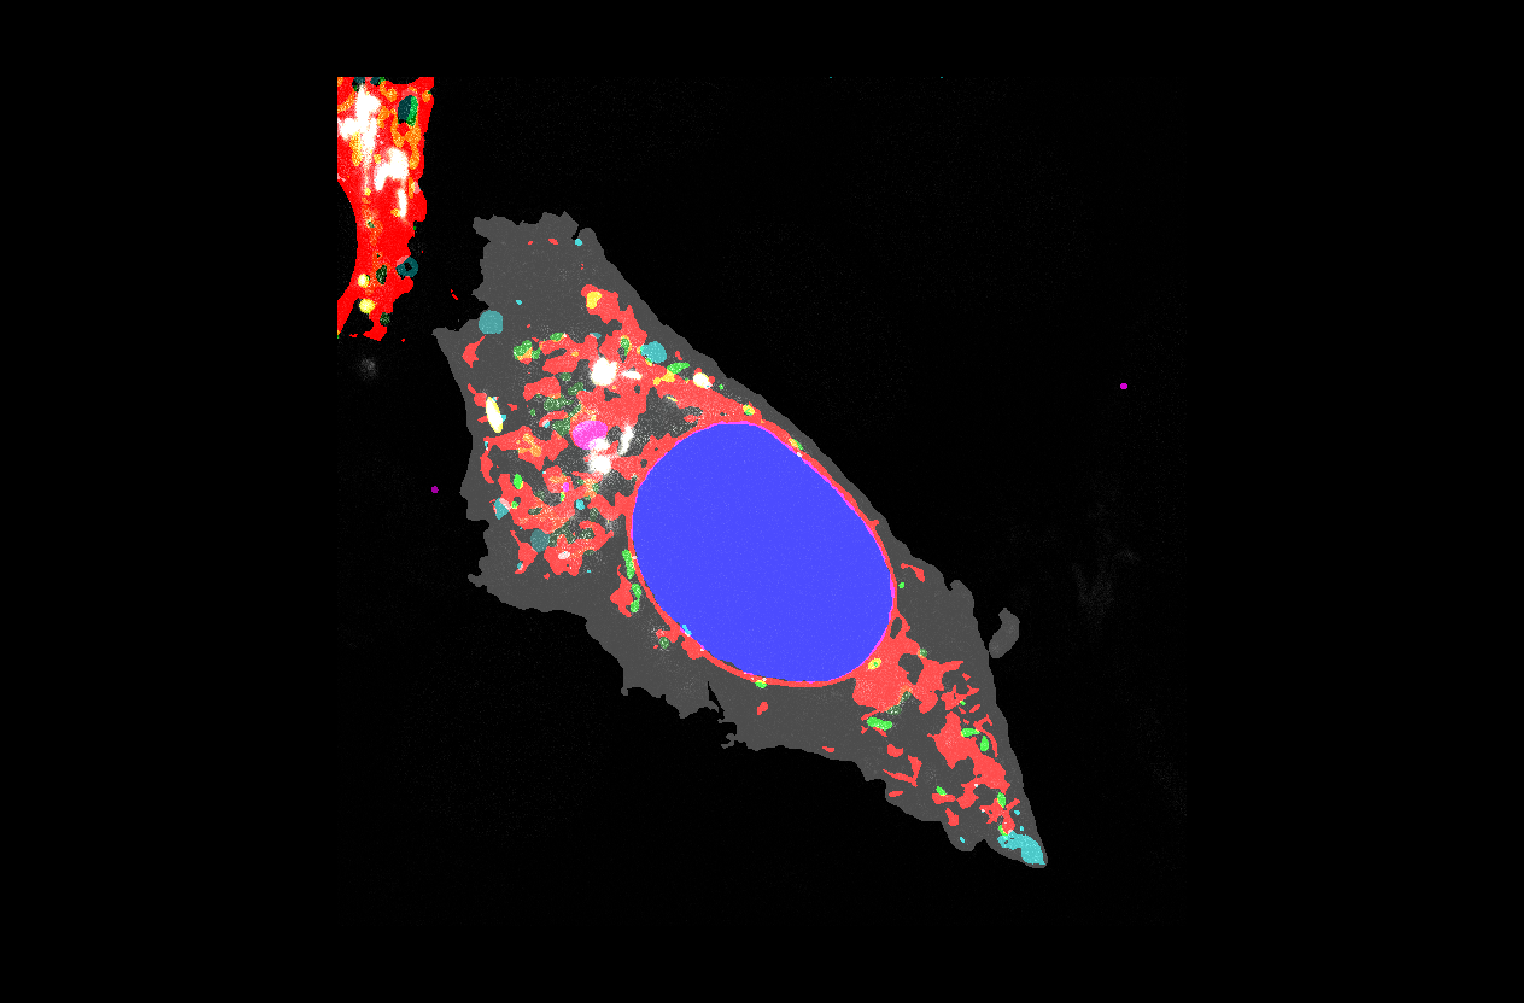

In [13]:
viewer.add_image(cell_seg, colormap='gray', opacity=0.3, blending ='additive')

viewer.add_image(nuc_seg, colormap='blue', blending ='additive')
viewer.add_image(lyso_seg, colormap='cyan', blending ='additive')
viewer.add_image(mito_seg, colormap='green', blending ='additive')
viewer.add_image(golgi_seg, colormap='yellow', blending ='additive')
viewer.add_image(perox_seg, colormap='bop orange', blending ='additive')
viewer.add_image(ER_seg, colormap='red', blending ='additive')
viewer.add_image(LD_seg, colormap='magenta', blending ='additive')

nbscreenshot(viewer, canvas_only=True)

In [14]:
viewer.close()

-------------------------
# **regionprops**

To measure the amount, size, and shape of the individual organelles, we will utilize `skimage.measure.regionprops`. These measurements can be collected based on pixel/voxel units (assuming the image is isotropic in all dimensions) and or "real-world" units. Since most confocal microscope images are anisotropic (mostly with respect to the Z dimension), we will preferentially utilize real-world units. Luckily, regionprops>=0.20.0 has incorporated a spacing parameter that can handle anisotropic data.

Similar concepts will also be applied to measure the cell, cytoplasm, and nucleus below as well in notebook 1.4.

> ###### **Below, we have listed the properties that are supported in 3D and the properties that support scaling to real-world units**
> ###### 📝 **The regionprop property names correspond to 2D measurements even for those that are able to function in 3D (i.e. "area" is actually "volume" when a 3D image is being processed, etc.)**

In [16]:
labels = label(nuc_seg )
NUC_CH = 0
rp = regionprops(labels, intensity_image=raw_img_data[NUC_CH], spacing=scale)

supported = [] 
unsupported = []

for prop in rp[0]:
    try:
        rp[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties for 3D analysis:")
print("  " + "\n  ".join(supported))

KeyboardInterrupt: 

In [ ]:
print("Properties only supported in 2D:")
print("  " + "\n  ".join(unsupported))

###### Below, we have listed the observed properties and the affect of scaling via real-world units (microns):

**Scaled**
>- volume: n * zyx
>- equivalent diameter: n * zyx**(1/3)
>- centroid-0: n * z
>- centroid-1: n * y
>- centroid-2: n * x
>- surface_area: varies by shape and orientation

**Not Scaled**
>- bbox (0-5)
>- euler_number
>- extent
>- max_intensity
>- mean_intensity
>- min_intensity
>- standard_deviation_intensity

# ***BUILD FUNCTION PROTOTYPE***

## **`0` - Apply Cell Mask**
To ensure we are performing single cell analysis, we will apply the cell segmentation as a mask.

> ###### 📝 **The Golgi body segmentation will be the example used throughout this notebook**

In [17]:
golgi_masked = apply_mask(golgi_seg, cell_seg)

## **`1` - Build the list of measurements we want to include from regionprops**

In [18]:
# start with LABEL
test_properties = ["label"]

# add position
test_properties = test_properties + ["centroid", "bbox"]

# add area
test_properties = test_properties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements
test_properties = test_properties + ["extent", "euler_number", "solidity", "axis_major_length"] # "feret_diameter_max", "axis_minor_length"]

# add intensity values (used for quality checks only)
test_properties = test_properties + ["min_intensity", "max_intensity", "mean_intensity"]

test_properties

['label',
 'centroid',
 'bbox',
 'area',
 'equivalent_diameter',
 'extent',
 'euler_number',
 'solidity',
 'axis_major_length',
 'min_intensity',
 'max_intensity',
 'mean_intensity']

## **`2` - Add additional measurements as *"extra_properties"* with custom functions**

In [19]:
# create a function to include the standard deviation of intensities (for quality checks only)
def _standard_deviation_intensity(region, intensities):
    return np.std(intensities[region])

test_extra_properties = [_standard_deviation_intensity]

## **`3` - Run regionprops and export values as a pandas dataframe**

In [20]:
test_props = regionprops_table(golgi_masked,
                            intensity_image=raw_img_data[0], 
                            properties=test_properties,
                            extra_properties=test_extra_properties,
                            spacing=scale)

In [21]:
test_props_unscaled = regionprops_table(golgi_masked,
                            intensity_image=raw_img_data[0], 
                            properties=test_properties,
                            extra_properties=test_extra_properties)

In [22]:
test_props_table = pd.DataFrame(test_props)

test_org_name = "golgi"
test_props_table.insert(1, "object", test_org_name)
test_props_table.rename(columns={"area": "volume"}, inplace=True)

round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
test_props_table.insert(loc=2, column="scale", value=f"{round_scale}")

## **`4` - Add additional measurements**

- surface area
- surface area to volume ratio

In [23]:
# creating a function to measure the surface area of each object. This function utilizes "marching_cubes" to generate a mesh (non-pixelated object)
def _surface_area_from_props(labels: np.ndarray,
                             props: dict,
                             scale: Union[tuple, None]=None):
    """ 
    a function for getting surface area of volumetric objects

    Parameters:
    ----------
    lables:
        the segmentation np.ndarray with each object labeled a different number
    props:
        region props dictionary resulting from the _my_props_to_dict() function
    spacing:
        tuple of the dimension lengths in the same order as the dimension of your np.ndarray labels input
    """
    surface_areas = np.zeros(len(props["label"]))

    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[
            max(props["bbox-0"][index] - 1, 0) : min(props["bbox-3"][index] + 1, labels.shape[0]),
            max(props["bbox-1"][index] - 1, 0) : min(props["bbox-4"][index] + 1, labels.shape[1]),
            max(props["bbox-2"][index] - 1, 0) : min(props["bbox-5"][index] + 1, labels.shape[2]),
        ]
        volume = volume == lab
        if scale is None:
            scale=(1.0,) * labels.ndim
        verts, faces, _normals, _values = marching_cubes(volume,
                                                         method="lewiner",
                                                         spacing=scale,
                                                         level=0)
        
        surface_areas[index] = mesh_surface_area(verts, faces)

    return surface_areas

In [24]:
# props["surface_area"] = surface_area_from_props(nuc_seg, props)
test_surface_area_tab = pd.DataFrame(_surface_area_from_props(golgi_masked, test_props, scale))

test_props_table.insert(12, "surface_area", test_surface_area_tab)
test_props_table.insert(14, "SA_to_volume_ratio", test_props_table["surface_area"].div(test_props_table["volume"]))

pd.set_option('display.max_columns', None)
test_props_table

,label,object,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,_standard_deviation_intensity
0,1,golgi,"(0.3891, 0.0799, 0.0799)",3.047327,25.376828,18.171967,1,274,181,16,371,280,153.181577,33.752838,4.538332,4.009626,0.094394,1,0.274931,10.776564,0.0,4469.0,94.098772,245.987753
1,3,golgi,"(0.3891, 0.0799, 0.0799)",3.561908,19.649771,18.060408,2,221,207,16,272,255,59.918405,13.268289,4.515911,2.937235,0.155958,1,0.460220,5.637385,0.0,2606.0,58.757717,175.105745
2,4,golgi,"(0.3891, 0.0799, 0.0799)",1.387752,25.729279,14.372799,2,305,171,6,342,192,15.822502,2.467480,6.412414,1.676557,0.319820,1,0.822167,3.121573,0.0,2641.0,116.304829,232.007950
3,5,golgi,"(0.3891, 0.0799, 0.0799)",1.273343,26.119869,19.036417,2,319,230,6,336,248,10.881411,1.941216,5.605460,1.547718,0.638889,1,0.899885,1.793660,0.0,2435.0,89.823529,248.016174
4,6,golgi,"(0.3891, 0.0799, 0.0799)",1.962179,22.591572,16.149313,3,266,190,9,300,216,20.326122,3.668949,5.540040,1.913585,0.278658,1,0.773822,3.186420,0.0,1614.0,47.810555,149.373008
5,7,golgi,"(0.3891, 0.0799, 0.0799)",1.949098,29.841696,18.361525,3,362,222,9,386,239,13.867751,2.479892,5.592080,1.679363,0.408088,1,0.817512,2.516640,0.0,1961.0,142.181181,232.675366
6,9,golgi,"(0.3891, 0.0799, 0.0799)",3.215435,20.061638,24.048551,6,245,295,11,258,309,7.994387,1.159269,6.896061,1.303352,0.513187,1,0.882798,2.023213,0.0,2244.0,176.486081,266.480755
7,12,golgi,"(0.3891, 0.0799, 0.0799)",3.479406,22.362202,10.476941,7,261,123,12,296,142,17.351123,2.983813,5.815083,1.786176,0.361504,1,0.821038,2.754456,0.0,1838.0,144.111481,223.479844
8,13,golgi,"(0.3891, 0.0799, 0.0799)",4.394240,21.686182,22.123955,8,252,241,15,285,312,44.216452,9.249325,4.780506,2.604377,0.227181,1,0.477876,6.876938,0.0,2143.0,97.881374,211.195413
9,14,golgi,"(0.3891, 0.0799, 0.0799)",4.077867,27.734440,14.141493,9,334,167,13,363,187,15.639289,3.249427,4.812937,1.837678,0.564224,1,0.895962,2.300854,0.0,1540.0,90.431627,183.508867


# ***EXECUTE FUNCTION PROTOTYPE***

## **Define `get_org_morphology_3D()` function**

In [25]:
def _get_org_morphology_3D(segmentation_img: np.ndarray, 
                           seg_name: str, 
                           intensity_img, 
                           mask: np.ndarray, 
                           scale: Union[tuple, None]=None):
    """
    Parameters
    ------------
    segmentation_img:
        a 3D (ZYX) np.ndarray of segmented objects 
    seg_name: str
        a name or nickname of the object being measured; this will be used for record keeping in the output table
    intensity_img:
        a 3D (ZYX) np.ndarray contain gray scale values from the "raw" image the segmentation is based on )single channel)
    mask:
        a 3D (ZYX) binary np.ndarray mask of the area to measure from
    scale: tuple, optional
        a tuple that contains the real world dimensions for each dimension in the image (Z, Y, X)


    Regionprops measurements:
    ------------------------
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length',
    'max_intensity',
    'mean_intensity',
    'min_intensity']

    Additional measurements:
    -----------------------
    ['standard_deviation_intensity',
    'surface_area']


    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each object in the segmentation image (rows) and the regionprops object
    
    """
    ###################################################
    ## MASK THE ORGANELLE OBJECTS THAT WILL BE MEASURED
    ###################################################
    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    input_labels = _assert_uint16_labels(segmentation_img)

    # mask
    input_labels = apply_mask(input_labels, mask)

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "solidity", "axis_major_length"] # ,"feret_diameter_max", "axis_minor_length"]

    # add intensity values (used for quality checks)
    properties = properties + ["min_intensity", "max_intensity", "mean_intensity"]

    #######################
    ## ADD EXTRA PROPERTIES
    #######################
    def standard_deviation_intensity(region, intensities):
        return np.std(intensities[region])

    extra_properties = [standard_deviation_intensity]

    ##################
    ## RUN REGIONPROPS
    ##################
    props = regionprops_table(input_labels, 
                           intensity_image=intensity_img, 
                           properties=properties,
                           extra_properties=extra_properties,
                           spacing=scale)

    props_table = pd.DataFrame(props)
    props_table.insert(0, "object", seg_name)
    props_table.rename(columns={"area": "volume"}, inplace=True)

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(segmentation_img.ndim))}") 

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(_surface_area_from_props(input_labels, props, scale))

    props_table.insert(12, "surface_area", surface_area_tab)
    props_table.insert(14, "SA_to_volume_ratio", props_table["surface_area"].div(props_table["volume"]))

    ################################################################
    ## ADD SKELETONIZATION OPTION FOR MEASURING LENGTH AND BRANCHING
    ################################################################


    return props_table

## **Run `_get_org_morphology_3D` function**

In [26]:
org_img = raw_img_data[0]
seg_name = 'golgi'
org_obj = golgi_seg
cell_mask = cell_seg

# with scale
golgi_table = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask, scale=scale)
# without scale
golgi_table_unscaled = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask, scale=None)

> **Table with scaled metrics**

In [27]:
golgi_table

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,golgi,1,"(0.3891, 0.0799, 0.0799)",3.047327,25.376828,18.171967,1,274,181,16,371,280,153.181577,33.752838,4.538332,4.009626,0.094394,1,0.274931,10.776564,0.0,4469.0,94.098772,245.987753
1,golgi,3,"(0.3891, 0.0799, 0.0799)",3.561908,19.649771,18.060408,2,221,207,16,272,255,59.918405,13.268289,4.515911,2.937235,0.155958,1,0.460220,5.637385,0.0,2606.0,58.757717,175.105745
2,golgi,4,"(0.3891, 0.0799, 0.0799)",1.387752,25.729279,14.372799,2,305,171,6,342,192,15.822502,2.467480,6.412414,1.676557,0.319820,1,0.822167,3.121573,0.0,2641.0,116.304829,232.007950
3,golgi,5,"(0.3891, 0.0799, 0.0799)",1.273343,26.119869,19.036417,2,319,230,6,336,248,10.881411,1.941216,5.605460,1.547718,0.638889,1,0.899885,1.793660,0.0,2435.0,89.823529,248.016174
4,golgi,6,"(0.3891, 0.0799, 0.0799)",1.962179,22.591572,16.149313,3,266,190,9,300,216,20.326122,3.668949,5.540040,1.913585,0.278658,1,0.773822,3.186420,0.0,1614.0,47.810555,149.373008
5,golgi,7,"(0.3891, 0.0799, 0.0799)",1.949098,29.841696,18.361525,3,362,222,9,386,239,13.867751,2.479892,5.592080,1.679363,0.408088,1,0.817512,2.516640,0.0,1961.0,142.181181,232.675366
6,golgi,9,"(0.3891, 0.0799, 0.0799)",3.215435,20.061638,24.048551,6,245,295,11,258,309,7.994387,1.159269,6.896061,1.303352,0.513187,1,0.882798,2.023213,0.0,2244.0,176.486081,266.480755
7,golgi,12,"(0.3891, 0.0799, 0.0799)",3.479406,22.362202,10.476941,7,261,123,12,296,142,17.351123,2.983813,5.815083,1.786176,0.361504,1,0.821038,2.754456,0.0,1838.0,144.111481,223.479844
8,golgi,13,"(0.3891, 0.0799, 0.0799)",4.394240,21.686182,22.123955,8,252,241,15,285,312,44.216452,9.249325,4.780506,2.604377,0.227181,1,0.477876,6.876938,0.0,2143.0,97.881374,211.195413
9,golgi,14,"(0.3891, 0.0799, 0.0799)",4.077867,27.734440,14.141493,9,334,167,13,363,187,15.639289,3.249427,4.812937,1.837678,0.564224,1,0.895962,2.300854,0.0,1540.0,90.431627,183.508867


> **Table with unscaled metrics**

In [28]:
golgi_table_unscaled

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,golgi,1,"(1.0, 1.0, 1.0)",7.831360,317.720085,227.514599,1,274,181,16,371,280,10569.193359,13597.0,0.777318,29.612938,0.094394,1,0.274931,126.551070,0.0,4469.0,94.098772,245.987753
1,golgi,3,"(1.0, 1.0, 1.0)",9.153789,246.016838,226.117867,2,221,207,16,272,255,3806.012939,5345.0,0.712070,21.692837,0.155958,1,0.460220,53.886235,0.0,2606.0,58.757717,175.105745
2,golgi,4,"(1.0, 1.0, 1.0)",3.566398,322.132797,179.948692,2,305,171,6,342,192,995.510376,994.0,1.001519,12.382146,0.319820,1,0.822167,39.078061,0.0,2641.0,116.304829,232.007950
3,golgi,5,"(1.0, 1.0, 1.0)",3.272379,327.023018,238.337596,2,319,230,6,336,248,707.810669,782.0,0.905129,11.430609,0.638889,1,0.899885,19.426751,0.0,2435.0,89.823529,248.016174
4,golgi,6,"(1.0, 1.0, 1.0)",5.042625,282.848444,202.190798,3,266,190,9,300,216,1351.348999,1478.0,0.914309,14.132704,0.278658,1,0.773822,39.084957,0.0,1614.0,47.810555,149.373008
5,golgi,7,"(1.0, 1.0, 1.0)",5.009009,373.620621,229.887888,3,362,222,9,386,239,883.676392,999.0,0.884561,12.402873,0.408088,1,0.817512,26.521918,0.0,1961.0,142.181181,232.675366
6,golgi,9,"(1.0, 1.0, 1.0)",8.263383,251.173448,301.089936,6,245,295,11,258,309,435.202484,467.0,0.931911,9.625857,0.513187,1,0.882798,14.478316,0.0,2244.0,176.486081,266.480755
7,golgi,12,"(1.0, 1.0, 1.0)",8.941764,279.976705,131.172213,7,261,123,12,296,142,1112.407715,1202.0,0.925464,13.191736,0.361504,1,0.821038,34.207961,0.0,1838.0,144.111481,223.479844
8,golgi,13,"(1.0, 1.0, 1.0)",11.292807,271.512882,276.993827,8,252,241,15,285,312,3019.873047,3726.0,0.810487,19.234523,0.227181,1,0.477876,85.513274,0.0,2143.0,97.881374,211.195413
9,golgi,14,"(1.0, 1.0, 1.0)",10.479756,347.237586,177.052712,9,334,167,13,363,187,1093.926758,1309.0,0.835697,13.572099,0.564224,1,0.895962,28.765008,0.0,1540.0,90.431627,183.508867


In [29]:
# Will result in FALSE because the _standard_deviation_intensity function was used in the prototyping 
# instead of the standard_deviation_intensity function from stats.py
golgi_table.equals(test_props_table)

False

## **Compare to finalized `get_org_morphology_3D` function**

In [30]:
from infer_subc.utils.stats import get_org_morphology_3D

golgi_table_final = get_org_morphology_3D(segmentation_img=org_obj,
                                          seg_name='golgi',
                                          intensity_img=org_img, 
                                          mask=cell_mask, 
                                          scale=scale)

In [31]:
golgi_table.equals(golgi_table_final)

True